# Importing the libraries

In [1]:
import string

# data manipulation & vizualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# nltk imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# sklearn imports
from sklearn import ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df = pd.read_csv("dataset/flipkart_com-ecommerce_sample.csv")

df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."


In [4]:
# no of rows and columns

print(df.shape)

(20000, 15)


In [5]:
# null values in each column 

print(df.isnull().sum())

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 78
discounted_price             78
image                         3
is_FK_Advantage_product       0
description                   2
product_rating                0
overall_rating                0
brand                      5864
product_specifications       14
dtype: int64


In [6]:
# description -> predict primary product category 

# get primary product category

def get_primary_category(product_category_tree):
    categories = product_category_tree.split(">>")
    if len(categories) == 1:
        return categories[0][2:-2].strip()
    else:
        return categories[0][2:].strip()


primary_categories = df["product_category_tree"].apply(get_primary_category)
primary_categories_unique = primary_categories.value_counts()
final_categories_idx = primary_categories_unique < 10
final_categories = primary_categories_unique[final_categories_idx]

print(final_categories)

Clovia Women's Full Coverage Bra                        9
Vishudh Printed Women's Straight Kurta                  8
Lilliput Top Baby Girl's  Combo                         8
Olvin Aviator Sunglasses                                7
Clovia Women's T-Shirt Bra                              6
                                                       ..
Nine Maternity Wear Women's Fit and Flare Dress         1
LondonHouze Printed Women's Round Neck Grey T-Shirt     1
SMART DENIM Solid Women's White Denim Shorts            1
SAY Thread Wounded Candle 10\" Set of 4 pcs Solid...    1
Oly Two Fit Fit Women's Black Jeans                     1
Name: product_category_tree, Length: 237, dtype: int64


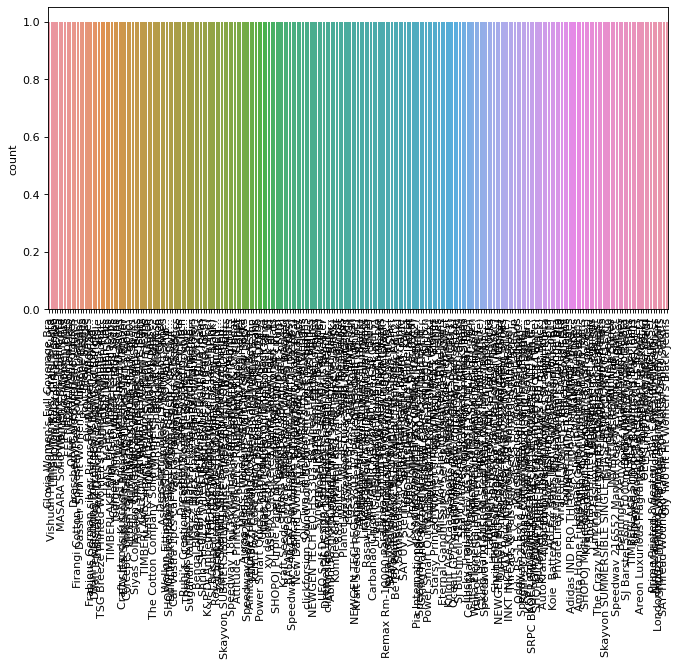

In [11]:
plt.figure(figsize=(10, 5), dpi=80)

sns.countplot(x=final_categories.index)
plt.xticks(rotation = 90)

plt.show()

In [6]:
new_df = pd.DataFrame()
new_df["description"] = df["description"]
new_df["primary_category"] = df["product_category_tree"].apply(get_primary_category)

least_freq_categories = new_df["primary_category"].value_counts()  
to_remove = least_freq_categories[least_freq_categories < 10].index
new_df["primary_category"].replace(to_remove, np.nan, inplace=True)

new_df.shape

(20000, 2)

In [7]:
new_df.isnull().sum()

description           2
primary_category    332
dtype: int64

In [8]:
new_df.dropna(inplace = True)

In [9]:
print(new_df.shape)

(19666, 2)


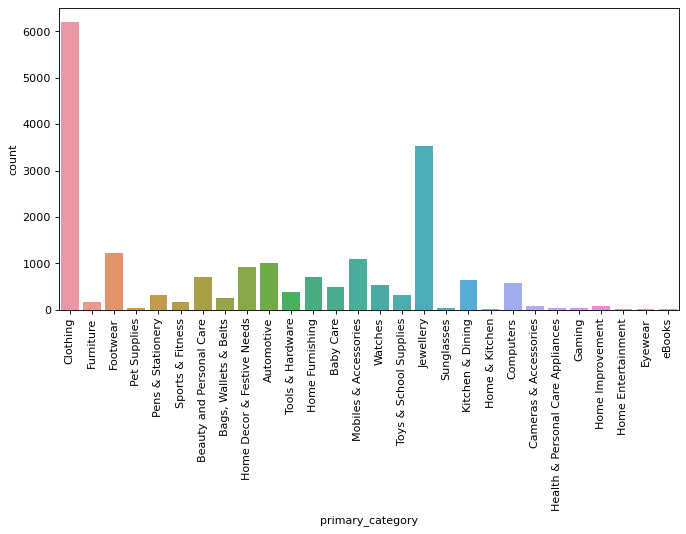

In [24]:
plt.figure(figsize=(10, 5), dpi=80)

sns.countplot(x="primary_category", data = new_df)
plt.xticks(rotation = 90)

plt.show()

In [113]:
lemmatizer = WordNetLemmatizer()

In [114]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_simple_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [142]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)
stops, string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kusha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


({'!',
  '"',
  '#',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '*',
  '+',
  ',',
  '-',
  '.',
  '/',
  ':',
  ';',
  '<',
  '=',
  '>',
  '?',
  '@',
  '[',
  '\\',
  ']',
  '^',
  '_',
  '`',
  'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',


In [116]:
def clean_description(words):
    output_words = []
    for w in words.split():
        if w.lower() not in stops:
            pos = nltk.pos_tag([w])
            clean_word = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
            output_words.append(clean_word.lower())
    return " ".join(output_words)

In [117]:
desc = new_df["description"].apply(clean_description)

print(desc)

KeyboardInterrupt: 

In [119]:
X = np.array(new_df["description"])
y = np.array(new_df["primary_category"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=73)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14749,)
(14749,)
(4917,)
(4917,)


In [120]:
count_vec = CountVectorizer(max_features = 2000)
X_train_features = count_vec.fit_transform(X_train)

In [121]:
X_train_features.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [123]:
count_vec.get_feature_names()

['01',
 '10',
 '100',
 '1000',
 '1099',
 '11',
 '110',
 '1100',
 '1199',
 '12',
 '120',
 '1200',
 '1299',
 '13',
 '1332',
 '1380',
 '1399',
 '14',
 '149',
 '1499',
 '15',
 '150',
 '152',
 '1599',
 '16',
 '1699',
 '17',
 '175',
 '1799',
 '18',
 '180',
 '18k',
 '19',
 '199',
 '20',
 '200',
 '2015',
 '21',
 '22',
 '220',
 '225',
 '23',
 '230',
 '24',
 '240',
 '249',
 '25',
 '250',
 '26',
 '269',
 '27',
 '28',
 '299',
 '2d',
 '30',
 '300',
 '3000',
 '31',
 '32',
 '325',
 '329',
 '33',
 '330',
 '34',
 '349',
 '35',
 '350',
 '36',
 '360',
 '38',
 '399',
 '3a',
 '3d',
 '40',
 '400',
 '42',
 '449',
 '45',
 '450',
 '499',
 '4th',
 '50',
 '500',
 '549',
 '550',
 '599',
 '5v',
 '60',
 '600',
 '60cms',
 '649',
 '650',
 '685',
 '699',
 '70',
 '700',
 '749',
 '75',
 '750',
 '799',
 '80',
 '800',
 '849',
 '850',
 '899',
 '90',
 '900',
 '920',
 '925',
 '949',
 '99',
 '995',
 '999',
 '9a',
 'a5',
 'able',
 'about',
 'above',
 'abstract',
 'ac',
 'access',
 'accessories',
 'accessory',
 'according',
 'a

In [124]:
X_test_features = count_vec.transform(X_test)

In [125]:
X_test_features

<4917x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 171334 stored elements in Compressed Sparse Row format>

In [126]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_features, y_train)

SVC()

In [127]:
y_pred = clf.predict(X_test_features)

y_pred

array(['Jewellery', 'Computers', 'Beauty and Personal Care', ...,
       'Sports & Fitness', 'Tools & Hardware', 'Kitchen & Dining'],
      dtype=object)

In [128]:


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                                   precision    recall  f1-score   support

                       Automotive       0.96      0.95      0.96       234
                        Baby Care       0.97      0.77      0.86       141
            Bags, Wallets & Belts       0.98      0.78      0.87        60
         Beauty and Personal Care       0.95      0.94      0.94       176
            Cameras & Accessories       1.00      0.65      0.79        20
                         Clothing       0.92      1.00      0.96      1517
                        Computers       0.89      0.88      0.89       153
                          Eyewear       1.00      1.00      1.00         2
                         Footwear       0.98      0.94      0.96       334
                        Furniture       1.00      0.87      0.93        45
                           Gaming       0.86      0.50      0.63        12
Health & Personal Care Appliances       1.00      0.14      0.25         7
                   Home 

C:\Users\kusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
y_train_pred = clf.predict(X_train_features)

y_train_pred

array(['Baby Care', 'Mobiles & Accessories', 'Watches', ...,
       'Home Decor & Festive Needs', 'Watches', 'Jewellery'], dtype=object)

In [136]:
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

                                   precision    recall  f1-score   support

                       Automotive       0.99      0.99      0.99       778
                        Baby Care       0.96      0.85      0.90       342
            Bags, Wallets & Belts       0.98      0.92      0.95       205
         Beauty and Personal Care       0.98      0.98      0.98       534
            Cameras & Accessories       1.00      0.90      0.95        62
                         Clothing       0.99      1.00      0.99      4680
                        Computers       0.90      0.98      0.94       425
                          Eyewear       1.00      1.00      1.00         8
                         Footwear       0.99      0.97      0.98       893
                        Furniture       0.99      0.93      0.96       135
                           Gaming       1.00      0.78      0.88        23
Health & Personal Care Appliances       1.00      0.50      0.67        36
                   Home 

In [129]:
np.savetxt("categories_predictions.csv", y_pred, fmt="%s")

In [131]:
y_test

array(['Jewellery', 'Computers', 'Beauty and Personal Care', ...,
       'Sports & Fitness', 'Tools & Hardware', 'eBooks'], dtype=object)

In [139]:


rf = ensemble.RandomForestClassifier()
rf.fit(X_train_features, y_train)
y_pred = rf.predict(X_test_features)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_train, y_train_pred))

                                   precision    recall  f1-score   support

                       Automotive       0.98      0.97      0.98       234
                        Baby Care       0.95      0.75      0.84       141
            Bags, Wallets & Belts       1.00      0.92      0.96        60
         Beauty and Personal Care       0.97      0.97      0.97       176
            Cameras & Accessories       1.00      0.80      0.89        20
                         Clothing       0.97      1.00      0.98      1517
                        Computers       0.97      0.93      0.95       153
                          Eyewear       1.00      1.00      1.00         2
                         Footwear       1.00      0.97      0.98       334
                        Furniture       1.00      0.96      0.98        45
                           Gaming       0.69      0.75      0.72        12
Health & Personal Care Appliances       0.86      0.86      0.86         7
                   Home 

C:\Users\kusha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
y_train_pred = rf.predict(X_train_features)

print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

                                   precision    recall  f1-score   support

                       Automotive       1.00      1.00      1.00       778
                        Baby Care       1.00      0.99      0.99       342
            Bags, Wallets & Belts       1.00      1.00      1.00       205
         Beauty and Personal Care       1.00      1.00      1.00       534
            Cameras & Accessories       1.00      1.00      1.00        62
                         Clothing       1.00      1.00      1.00      4680
                        Computers       1.00      1.00      1.00       425
                          Eyewear       1.00      1.00      1.00         8
                         Footwear       1.00      1.00      1.00       893
                        Furniture       1.00      1.00      1.00       135
                           Gaming       1.00      1.00      1.00        23
Health & Personal Care Appliances       1.00      1.00      1.00        36
                   Home 